In [1]:
import os
import glob

import random
import pathlib
import numpy as np
from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.patches as patches
from PIL import Image
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.backends.cudnn.benchmark = True
# import cupy as cp

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import animation
from matplotlib.animation import PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

import time
import multiprocessing as m
import concurrent.futures
from sklearn.metrics import confusion_matrix


import pickle

In [3]:
resample_size = 10 # down sample from 28 to 10
thold = 0.22
pad_size = 0
size = resample_size*resample_size + 2*pad_size

ref_ind = 3.45          # Refractive index of Silicon
free_wv = 1.55e-6       # Wavelength in freespace
wv = free_wv/ref_ind    # Wavelength in Silicon

Hz = 3e8/wv
rect_length = 0.5e-6
layer_length = size*rect_length

z_min = size * rect_length * np.sqrt((4*rect_length**2)/wv**2-1) *1e6
print("确保全连接的最小距离是: " + str(z_min))
z = 100e-6 # 300e-6

num_layers = 1
lr = 0.1
batch_size = 100
epochs = 200

# RAM 64GB,8cpu ,size =100, num_process = 20, W --> 63 sec
# RAM 64GB,8cpu ,size =120, num_process = 20, W --> 129 sec

确保全连接的最小距离是: 99.42603230595124


### Build and train 2D-D2NN

In [4]:
def core_matrix(z):
    distance = z                         # distance bewteen two layers (3cm)
    wl = 3e8 / Hz                        # wave length
    wn = 2 * np.pi / wl                  # wave number
    c = rect_length
    w = np.zeros((size, size), dtype=np.complex64)

    for i in range(0, size, 1):
        s = i % size
        for k in range(i+1, size, 1):
            n = k % size
            # print(n-s)
            r_ns = np.sqrt(np.square(distance) + np.square(n * c - s * c))
            w[i][k] = np.exp(1j * wn * r_ns) * (1 / (2 * np.pi * r_ns) + 1 / (1j * wl)) * distance / (r_ns ** 2)
            

    w_diagonal = np.exp(1j * wn * distance) * (1 / (2 * np.pi * distance) + 1 / (1j * wl)) * distance / (distance*distance)
    w = w.T + w

    for i in range(0, size, 1):
        w[i][i] = w_diagonal
    
    w = (w * rect_length * 0.22e-6)     # !!!!!!!!!!!!
    return w

start = time.time()
W = core_matrix(z)
end = time.time()
print('NumPy计算时间：', end - start, 's')

print(np.shape(W))
# np.savetxt(r'W.txt', np.array(W),delimiter = ',')

NumPy计算时间： 0.05896759033203125 s
(100, 100)


In [5]:
def convert_to_col_vector(arr):
    vec = arr.view(arr.size(0), -1).t()
    return vec

def convert_to_mat(arr):
    mat = arr.t().view(arr.size(1), size, 1)
    return mat

def detector_region(x): # 输入是 x_intisity
    '''检测区域应该集中在中间部分'''
    i = size/165
    m = 10
    step_sizes = [10, 25, 40, 55, 70, 85, 100, 115, 130, 145]
    result = []
    for step in step_sizes:
        slice = x[:, int(i*step):int(i*(step+m)), :]
        result.append((slice / torch.max(slice)).mean(dim=(1, 2)).unsqueeze(-1))
    return torch.cat(result, dim=-1)
    # 测试过了， 一定要 归一化光强

    
class D2NN(torch.nn.Module):

    def __init__(self, num_layers = num_layers):
        super(D2NN, self).__init__()

        self.phase = torch.nn.Parameter(torch.from_numpy(np.random.random(size=(num_layers, size, 1)).astype('float32')),
                                         requires_grad=True)
    
        # self.sofmax = torch.nn.Softmax(dim = -1)
        self.W = torch.from_numpy(W).cuda()

    def forward(self, x): 
        x = torch.complex(x, torch.zeros_like(x))
        x = convert_to_col_vector(x) 
        P = torch.matmul(self.W, x)
        
        for i in range(self.phase.size(0)):
            phase = torch.exp(1j * self.phase[i].squeeze())
            P = torch.matmul(self.W, P * phase.unsqueeze(-1))
        
        x = convert_to_mat(P)
        x_intisity = torch.abs(x)**2
        output = detector_region(x_intisity) * 10      
        return output
    

class Resize(object):
    def __init__(self, size=10):
        self.size = size

    def __call__(self, image):
        image = np.array(image)
        extracted_image = image[5: 25: 2, 5: 25: 2]
        return extracted_image
    

training_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
def train_sce(num_layers):
    model_name ='.pth'
    model_save_path = "./mnist_"+str(size)+"_"+str(num_layers)+"_"
    
    transform = transforms.Compose([Resize(size=resample_size),
                                    transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))])

    train_dataset = torchvision.datasets.MNIST(root = "./data",train=True,transform=transform,download=True)
    val_dataset = torchvision.datasets.MNIST(root = "./data",train=False, transform=transform,download=True)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0, shuffle=True, pin_memory=True)
    val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

    model = D2NN(num_layers)
    # model.load_state_dict(torch.load(r'./test00_mnist_200_10_54.pth'), strict=False)
    model.cuda()

    # criterion = torch.nn.MSELoss(reduction='sum').cuda()    # MSE loss function
    criterion = torch.nn.CrossEntropyLoss().cuda() # justified
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))  # Adam optimizer
    # adjust_learning_rate = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs, eta_min=0, last_epoch=-1)
    
    adjust_learning_rate = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    for epoch in range(1,  1 + epochs):  # train
        
        model.train()

        train_len,train_running_counter, train_running_loss  = 0.0, 0.0, 0.0

        tk0 = tqdm(train_dataloader, ncols=100, total=int(len(train_dataloader)))
        for train_iter, train_data_batch in enumerate(tk0):
            
            train_images = train_data_batch[0].cuda()
            a = torch.zeros_like(train_images)
            b = torch.ones_like(train_images)
            train_images = torch.where(train_images >thold, b, a)  
            # train_images = torch.exp(1j*train_data_batch[0].cuda()*2*np.pi) # 相位图
            train_images = F.pad(train_images, pad=(pad_size,pad_size))
            train_labels = F.one_hot(train_data_batch[1].cuda(), num_classes=10).float()   # convert the label to one-hot form
            train_images = train_images.squeeze(dim=1)
            
            train_outputs = model(train_images)
            train_loss_ = criterion(train_outputs, train_labels)

            train_counter_ = torch.eq(torch.argmax(train_labels, dim=1), torch.argmax(train_outputs, dim=1)).float().sum()

            optimizer.zero_grad()
            train_loss_.backward()
            optimizer.step()

            train_len += batch_size
            train_running_loss += train_loss_.item()
            train_running_counter += train_counter_

            train_loss = float(train_running_loss / train_len)
            train_accuracy = float(train_running_counter / train_len)

            tk0.set_postfix({'Train_Accuracy': '{:.4f}'.format(train_accuracy), 'Train_Loss': '{:.4f}'.format(train_loss)})

        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_accuracy)


        adjust_learning_rate.step()

        
        with torch.no_grad():
            
            model.eval()
            val_len,val_running_counter, val_running_loss = 0.0, 0.0, 0.0

            tk1 = tqdm(val_dataloader, ncols=100, total=int(len(val_dataloader)))
            for val_iter, val_data_batch in enumerate(tk1):
                
                val_images = val_data_batch[0].cuda()
                a = torch.zeros_like(val_images)
                b = torch.ones_like(val_images)
                val_images = torch.where(val_images >thold, b, a)  # 图像预处理: 转成二值图
                # val_images = torch.exp(1j*val_data_batch[0].cuda()*2*np.pi) # phase object
                val_images = F.pad(val_images, pad=(pad_size,pad_size))
                val_labels = F.one_hot(val_data_batch[1].cuda(), num_classes=10).float()

                val_images = val_images.squeeze(dim=1)
                val_outputs = model(val_images)

                val_loss_ = criterion(val_outputs, val_labels)
                val_counter_ = torch.eq(torch.argmax(val_labels, dim=1), torch.argmax(val_outputs, dim=1)).float().sum()

                val_len += batch_size
                val_running_loss += val_loss_.item()
                val_running_counter += val_counter_

                val_loss = float(val_running_loss / val_len)
                val_accuracy = float(val_running_counter / val_len)

                
                tk1.set_postfix({'Val_Accuracy': '{:.4f}'.format(val_accuracy), 'Val_Loss': '{:.4f}'.format(val_loss)})

            training_history['val_loss'].append(val_loss)
            training_history['val_acc'].append(val_accuracy)

        torch.save(model.state_dict(), (model_save_path + str(epoch) + model_name))
        print('Model : "' + model_save_path + str(epoch) + model_name + '" saved.')
        
        with open("training_history"+"_"+str (size) +"_"+ str(num_layers)+".pkl", 'wb') as f:
            pickle.dump(training_history, f)

In [ ]:
train_sce(num_layers)

### ID2NN模型评估

In [ ]:
with open('training_history_300_5.pkl', 'rb') as f:
    training_history = pickle.load(f)
    
def plot_training_history():
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    # fig.set_dpi(300)
    # Plot training and validation loss
    epochs = len(training_history['train_loss'])
    axs[0].plot(range(1, epochs+1), [l for l in training_history['train_loss']], label='train_loss')
    axs[0].plot(range(1, epochs+1), [l for l in training_history['val_loss']], label='val_loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot training and validation accuracy
    axs[1].plot(range(1, epochs+1), [a for a in training_history['train_acc']], label='train_acc')
    axs[1].plot(range(1, epochs+1), [a for a in training_history['val_acc']], label='val_acc')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.savefig("./training_history.svg", dpi=600)
    plt.show()
plot_training_history()

np.max(training_history['val_acc']) # 超过 92.6%

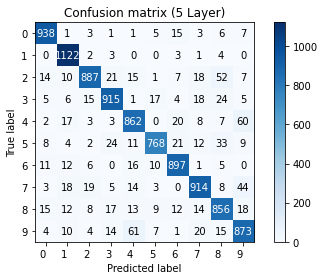

In [12]:
transform = transforms.Compose([Resize(size=resample_size),
                                    transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))])
val_dataset = torchvision.datasets.MNIST(root = "./data",train=False, transform=transform,download=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)

model = D2NN()
model.load_state_dict(torch.load(r'./mnist_300_5_200.pth'), strict=False)
model.cuda()
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for val_iter, val_data_batch in enumerate(val_dataloader):
        val_images = val_data_batch[0].cuda()
        a = torch.zeros_like(val_images)
        b = torch.ones_like(val_images)
        val_images = torch.where(val_images >thold, b, a)
        val_images = F.pad(val_images, pad=(pad_size,pad_size))
        val_labels = val_data_batch[1].numpy()

        val_images = val_images.squeeze(dim=1)
        val_outputs = model(val_images)

        val_preds = torch.argmax(val_outputs, dim=1).cpu().numpy()

        y_true.extend(val_labels)
        y_pred.extend(val_preds)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
# print(cm)

# Plot confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=np.arange(10),
       yticklabels=np.arange(10),
       title='Confusion matrix '+ '('+str(num_layers) +' Layer)',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
filename = "./confusion_matrix_"+str(num_layers)+"_layer.svg"
plt.savefig(filename, dpi=800)
plt.show()

### 调查层数对准确率的影响

## Extract the phase data

In [6]:
def get_phases(model):
    model.load_state_dict(torch.load(r'./mnist_100_1_136.pth'), strict=False)
    model.eval()
    print("model structure: ", model)
    for name, parameters in model.named_parameters():
        print(name, '::', parameters.size())
    # keys = model.state_dict().keys()
    # print(keys)

    phases = []
    for i in range(num_layers):
        phase = model.phase[i].detach().numpy()
        phases.append(phase)
    return np.array(phases)

model = D2NN()
phases = get_phases(model)

model structure:  D2NN()
phase :: torch.Size([1, 100, 1])


## Simulation in python

In [59]:
label_to_find = 3  # label to find
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)

# Find the index of the first sample with label equal to label_to_find
idx_list = [i for i, (data, label) in enumerate(train_dataset) if label == label_to_find][:20]

print(f"Indices of the first 20 samples with label {label_to_find}: {idx_list}")

Indices of the first 20 samples with label 3: [7, 10, 12, 27, 30, 44, 49, 50, 74, 86, 98, 107, 111, 130, 135, 136, 149, 157, 179, 181]


In [ ]:
def forward(x, phases):
    P = np.matmul(W, x)
    for phase in phases:
        P = np.matmul(W, P * np.exp(1j * phase))
    x_intensity = np.square(np.abs(P))
    # return detector plane
    return np.reshape(x_intensity, [1, size]) 


def detector_region_plot(detector_plane):
    fig, ax = plt.subplots()  # Create figure and axes
    fig.set_size_inches(18.5, 1)
    
    detector_plane = np.vstack((np.zeros([1, size]), detector_plane, np.zeros([1, size])))
    ax.imshow(detector_plane) # Display the image
    i = size/165
    m = i*10 # 这里需要乘 i, 上面不用
    lwidth = 2
    detector_0 = patches.Rectangle((i*10,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_1 = patches.Rectangle((i*25,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_2 = patches.Rectangle((i*40,0),m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_3 = patches.Rectangle((i*55,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_4 = patches.Rectangle((i*70,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_5 = patches.Rectangle((i*85,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_6 = patches.Rectangle((i*100,0),m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_7 = patches.Rectangle((i*115,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_8 = patches.Rectangle((i*130,0), m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')
    detector_9 = patches.Rectangle((i*145,0),m, 2, linewidth=lwidth, edgecolor='r', facecolor='none')


    # Add the patch to the Axes
    ax.add_patch(detector_0)
    ax.add_patch(detector_1)
    ax.add_patch(detector_2)
    ax.add_patch(detector_3)
    ax.add_patch(detector_4)
    ax.add_patch(detector_5)
    ax.add_patch(detector_6)
    ax.add_patch(detector_7)
    ax.add_patch(detector_8)
    ax.add_patch(detector_9)
    fig.set_dpi(100)
    plt.savefig("./output_plane.svg", dpi=600)
    plt.show()
    
def detector_region_value(x): 
    i = size/165
    m = 10
    step_sizes = [10, 25, 40, 55, 70, 85, 100, 115, 130, 145]
    Is = []
    for step in step_sizes:
        slice = x[:, int(i*step):int(i*(step+m))]
        Is.append((slice).mean()) 
    return Is # 输入的已经是光强了

Label:6


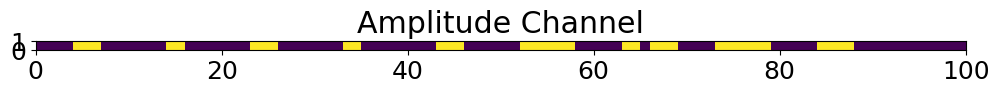

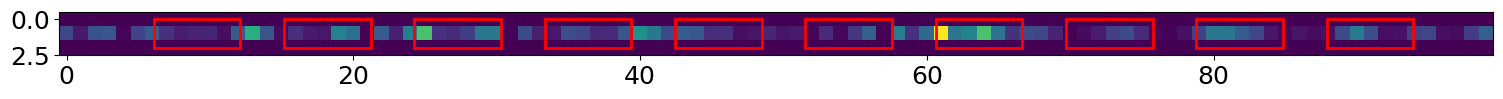

/environment/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


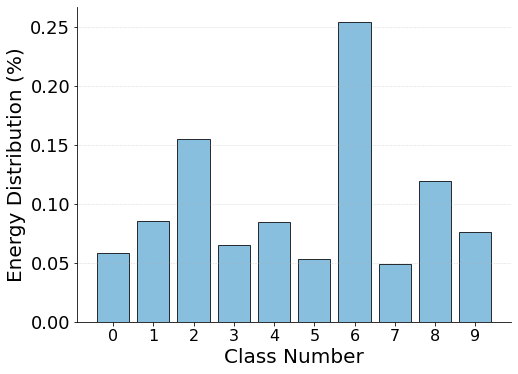

In [26]:
# 1 idx: 
# 2 idx: 199
# 3 idx: 12
idx = 36 # 20# 19

transform = transforms.Compose([Resize(size = resample_size),
                                transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))])
train_dataset = torchvision.datasets.MNIST(root = "./data",train=True,transform=transform,download=True)
U0 = train_dataset[idx][0]

a = torch.zeros_like(U0)
b = torch.ones_like(U0)
U0 = torch.where(U0 > thold, b, a) 

label= str(train_dataset[idx][1])
print("Label:" + str(train_dataset[idx][1]))

# U0 = torch.exp(1j*U0*2*np.pi) # 相位图
U0 = F.pad(U0, pad=(pad_size,pad_size))
U0 = U0.numpy()
# print(np.shape(U0))
U0 = np.reshape(U0,[size,1]) # convert to column vector

# fig_ = plt.figure(figsize=(12, 4))
# # Plot the phase channel in the first subplot
# plt.imshow(np.angle(np.reshape(U0,[1,size])),extent=[0, size, 0, 1])
# plt.title("Phase Channel")
# fig_.set_dpi(100)

fig = plt.figure(figsize=(12, 4))
# Plot the amplitude channel in the second subplot
plt.imshow(np.abs(np.reshape(U0,[1,size])),extent=[0, size, 0, 1])
plt.title("Amplitude Channel")
fig.set_dpi(100)

detector_plane = forward(U0,phases)

detector_region_plot(detector_plane)


plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(figsize=(8, 6))
langs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
ax.set_xticklabels(langs, fontsize=16)
ax.set_ylabel('Energy Distribution (%)', fontsize=20)
ax.set_xlabel('Class Number', fontsize=20)


Is = detector_region_value(detector_plane)
Is = Is / np.sum(Is)


ax.bar(langs, Is, color='#6baed6', alpha=0.8, edgecolor='black', linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
fig.tight_layout(pad=2)
plt.savefig("./output_distribution_SCE_idx_"+str(idx)+".svg", dpi=800, bbox_inches='tight')

plt.show()

### 查看有衍射层的横截面图

In [27]:
monitor = []

step = 1e-6
total = int(z/step)
def animate(input_field,i):
    input_field = np.reshape(input_field,[1,size])
    z = (i+1)*step
    W_temp = core_matrix(z)
    U1 = W_temp.dot(input_field.T)
    U1 = np.square(np.abs(U1))
    U1 = U1/np.max(U1)  # 场强归一化
    monitor.append(U1.T)

start = time.perf_counter()

for i in range(0,total):
    animate(U0,i)

P = np.matmul(W, U0) # 第一层衍射层的输入场
for phase in phases:
    P = P * np.exp(1j * phase) # 经过衍射层调制之后的场
    for i in range(0,total):  # 把调制之后场送入传播器
        animate(P,i)
    P = np.matmul(W, P) # 下一层衍射层的输入场
    x_intensity = np.square(np.abs(P))
    x_intensity = np.transpose(x_intensity)  
    monitor.append(x_intensity/np.max(x_intensity)) # 场强归一化

finish = time.perf_counter()
print(f'Finished in {round(finish-start,2)} seconds')
np.shape(monitor)

Finished in 9.78 seconds


(201, 1, 100)

(201, 1, 100)


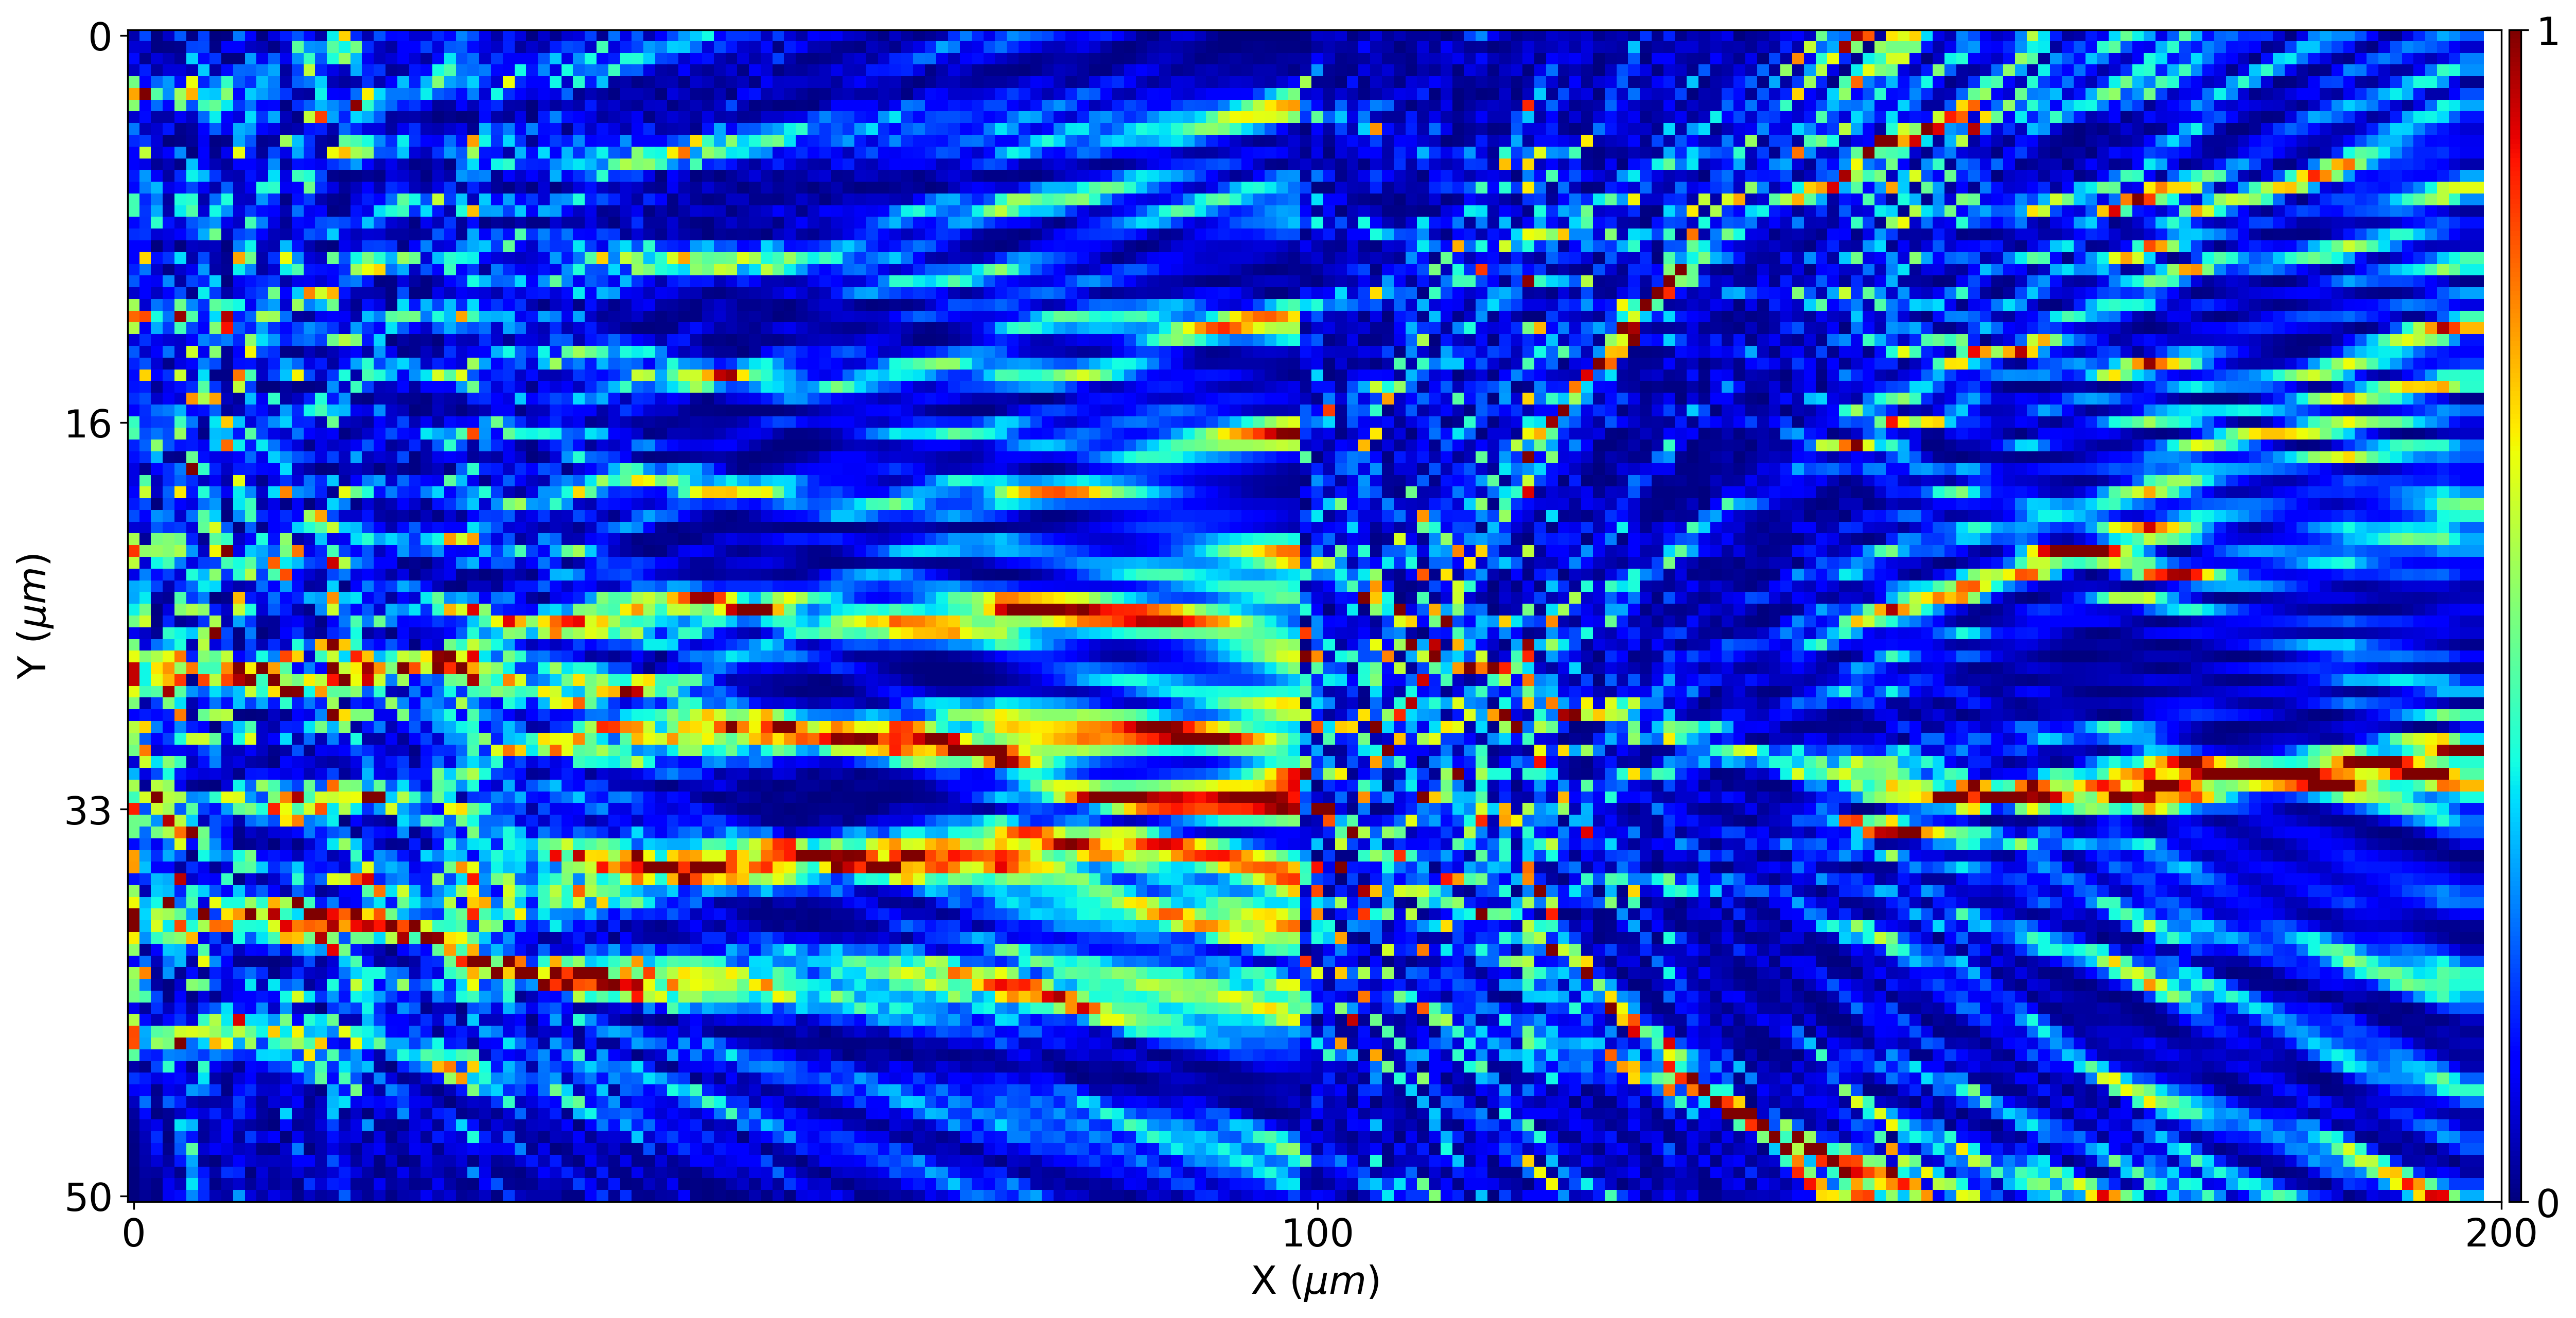

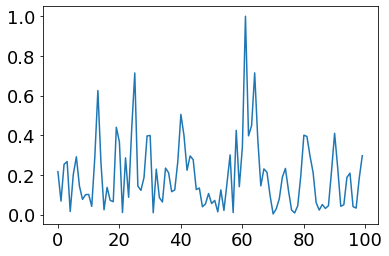

In [40]:
fig, ax = plt.subplots(figsize=(20, 20))
# 最后一列重复添加了，所以要删掉
# monitor = np.array(monitor)[0:np.shape(monitor)[0]-1,:,:]
print(np.shape(monitor))
fig.set_dpi(300)

im = ax.imshow(np.transpose(np.abs(np.squeeze(np.array(monitor)))),cmap='jet')
plt.xlabel('X ($\mu m$)')
plt.ylabel('Y ($\mu m$)')

x_ticks = np.linspace(0,np.shape(monitor)[0]+1 , num_layers+2)
x_tick_labels = []
i= 0
for tick in x_ticks:
    i+=1
    x_tick_labels.append('%.0f' % ((tick-i+1)*step*1e6))
plt.xticks(x_ticks, x_tick_labels)  # Set the tick locations and labels

y_ticks = np.linspace(0, np.shape(monitor)[2]-1, 4)  
y_tick_labels = ['%.0f' % (tick*rect_length*1e6) for tick in y_ticks] 
plt.yticks(y_ticks, y_tick_labels)

# create the colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="0.5%", pad=0.05)

# add the colorbar to the axis object
cbar = plt.colorbar(im, cax=cax, cmap='jet', ticks=[np.min(np.array(monitor)), 1])

figure_path = "./横截面图_5层_D"+label+".svg"
# plt.savefig(figure_path, dpi=600,bbox_inches = 'tight')

monitor_length = np.shape(monitor)[0]
monitor_output = np.squeeze(monitor)[monitor_length-1,:]
data = np.array(monitor_output)
plt.figure()
plt.plot(monitor_output)

In [41]:
print(np.shape(monitor))

(201, 1, 100)


## Prepare for the Simulation in FDTD

In [37]:
# input mask
transform = transforms.Compose([Resize(size = resample_size),
                                transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))])
train_dataset = torchvision.datasets.MNIST(root = "./data",train=True,transform=transform,download=True)
U0 = train_dataset[idx][0]

a = torch.zeros_like(U0)
b = torch.ones_like(U0)
U0 = torch.where(U0 > thold, b, a)  # 图像预处理: 转成二值图

U00 = np.reshape(U0,[1,size])
U00 = np.squeeze(np.array(U00))
print(np.shape(np.squeeze(np.array(U00)))) # phase 形状

np.savetxt("input.txt", U00.reshape(-1, 1), fmt='%d')

# phases
phases = np.squeeze(np.array(phases))
np.shape(phases)
if num_layers == 1:
    for i in range(0,size):
        while (phases[i] < 0):
                phases[i] += 2*np.pi
        while(phases[i] > 2*np.pi):
                phases[i] -= 2*np.pi
else:
    for i in range(0,num_layers):
        for j in range(0,size):
            while (phases[i][j] < 0):
                phases[i][j] += 2*np.pi
            while(phases[i][j] > 2*np.pi):
                phases[i][j] -= 2*np.pi

print(np.shape(phases)) # phase 形状
print(np.min(phases))
print(np.max(phases))

np.savetxt("phases.txt", phases.reshape(-1, 1), fmt='%.2f')


(100,)
(100,)
0.03147715
6.2430577
